# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

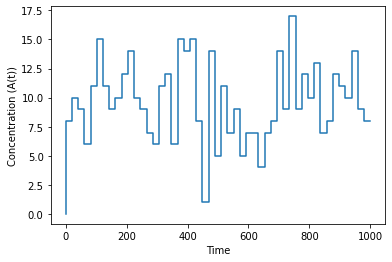

In [2]:
np.random.seed(7)

# Load a forward model
n_0 = 0
model = toy.stochastic.ProductionDegradationModel(n_0)

# Create some toy data
k = [0.1, 1]
times = np.linspace(0, 1000, 50)

values = model.simulate(k, times)
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)
# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0, 0.5], [0.3, 2])
# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('Time')
plt.ylabel('Concentration (A(t))')

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"

my_path = os.path.abspath(__file)


plt.savefig(my_path + '/prod_degr_model.pdf')

# plt.show()

# Calculating the posterior

In [3]:
import math

# Single stationary distribution
def s_stationary(theta, n):
    fct = math.factorial(n)
    frac = theta[1] / theta[0]
    return (frac ** n) * np.exp(-frac) / fct

def p_stationary(theta, data):
    prod = 1.0
    for d in data:
        prod *= s_stationary(theta, d[0])
    return prod

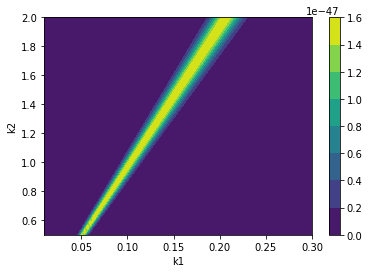

In [4]:
xlist = np.linspace(0.01, 0.3, 100)
ylist = np.linspace(0.5, 2, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = [[p_stationary([x, y], values[10:]) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
# ax.set_title('Contour plot of posterior')

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"

my_path = os.path.abspath(__file)

plt.xlabel("k1")
plt.ylabel("k2")
plt.savefig(my_path + '/prod_degr_posterior.pdf')

# plt.show()

# Compute integral

In [5]:
from scipy import integrate

def f(x, y):
    return p_stationary([x, y], values[10:])

def bounds_x(y):
    return [0.0, 0.3]

def bounds_y():
    return [0.5, 2]

res = integrate.nquad(f, [bounds_x, bounds_y])

print("integral is ="+str(res))

def normalized_posterior(x, y):
    return p_stationary([x, y], values[10:]) / res[0]

new_approx = integrate.nquad(normalized_posterior, [bounds_x, bounds_y])

print("new integral should be 1="+str(new_approx))


integral is =(3.9473804110212486e-49, 5.696996805929298e-49)
new integral should be 1=(0.9982564874830195, 1.1142026796040793e-08)


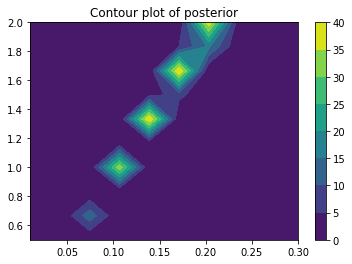

In [6]:
xlist = np.linspace(0.01, 0.3, 10)
ylist = np.linspace(0.5, 2, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = [[normalized_posterior(x, y) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute marginal distributions

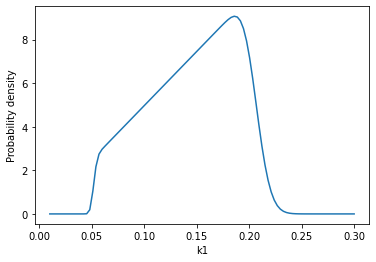

In [9]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.5, 2)[0]

thetas = np.linspace(0.01, 0.3, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_x(theta))

plt.plot(thetas, results)
plt.xlabel("k1")
plt.ylabel("Marginal probability density")
plt.savefig(my_path + '/prod_degr_margin_dist_x.pdf')
# plt.show()

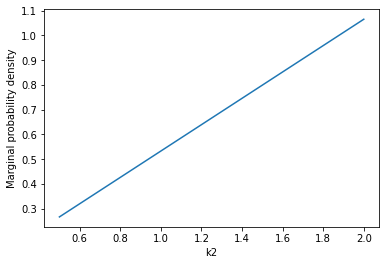

In [11]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.3)[0]

thetas = np.linspace(0.5, 2, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_y(theta))

plt.plot(thetas, results)
plt.xlabel("k2")
plt.ylabel("Marginal probability density")
plt.savefig(my_path + '/prod_degr_margin_dist_y.pdf')
# plt.show()

# Rejection ABC

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [9, 8, 7, 6]
resulting_kl = []

for error in error_thresholds:
    inter_kl = []
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior)
        # set threshold
        abc.sampler().set_threshold(error)
        # set target number of samples
        abc.set_n_samples(500)
        # log to screen
        abc.set_log_to_screen(True)
        print('Running...')
        samples  = abc.run()
        print('Done')

        samples_flat = np.array([item for sublist in samples for item in sublist])

        # computing the KDE and KL functions for x

        def marginal_distribution_x(x):
            partial_lam = lambda y : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0.5, 2)[0]

        def kl_func_x(y, kde_skl):
            part = marginal_distribution_x(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_x(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_x(y, kde_skl)
            return integrate.quad(fun, 0.013, 0.3)

        saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

        # computing the KDE and KL functions for x
        def marginal_distribution_y(y):
            partial_lam = lambda x : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0, 0.3)[0]

        def kl_func_y(y, kde_skl):
            part = marginal_distribution_y(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_y(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_y(y, kde_skl)
            return integrate.quad(fun, 0.5, 2)

        saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
        saved = saved_x + saved_y
        inter_kl.append(saved)

        print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))
    resulting_kl.append(inter_kl)

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     2      0.5              0:00.1
2     5      0.4              0:00.3
3     6      0.5              0:00.3
20    42     0.476190476      0:01.9
40    69     0.579710145      0:03.7
60    96     0.625            0:06.1
80    124    0.64516129       0:07.8
100   152    0.657894737      0:09.6
120   183    0.655737704918   0:11.6
140   205    0.682926829      0:13.0
160   225    0.711111111      0:14.0
180   251    0.717131474      0:15.1
200   283    0.706713781      0:16.3
220   311    0.707395498      0:17.6
240   337    0.712166172      0:18.7
260   359    0.724233983      0:19.6
280   382    0.732984293      0:20.5
300   408    0.735294118      0:21.6
320   433    0.739030023      0:22.7
340   461    0.737527115      0:23.8
360   485    0.742268041      0:25.1
380   509    0.746561886      0:26.3
400   534    0.749063670412   0:27.4
420   569    0.738137083      0:29.3
440   594    0.7

No handles with labels found to put in legend.


[[0.7934037176378508, 0.814403041530533, 0.7621318663184549, 0.788289059297759, 0.8018015519714402], [0.7472014583410287, 0.7228411404369586, 0.7410948584078627, 0.760811904339743, 0.7564977921857242], [0.6743269500945306, 0.654551884031685, 0.6977660783085141, 0.694691761509227, 0.6585507544964495], [0.6002390886974823, 0.6109939961665386, 0.6083745777998404, 0.5825968358061836, 0.6157082288249569]]


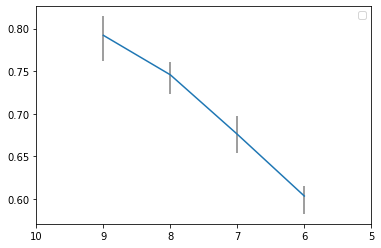

In [12]:
res_rej_abc = resulting_kl

print(resulting_kl)

resulting_kl = np.array(resulting_kl)

mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(10, 5)

plt.legend()
plt.show()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')
plt.show()

# Modified PMC

In [16]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [9, 8, 7, 6]
resulting_kl = []

for error in error_thresholds:
    inter_kl = []
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([1.5 * error, 1.3 * error, error]))

        # produce intermediate distributions of size 200
        abc.sampler().set_intermediate_size(100)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        samples_flat = samples

        # computing the KDE and KL functions for x

        def marginal_distribution_x(x):
            partial_lam = lambda y : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0.5, 2)[0]

        def kl_func_x(y, kde_skl):
            part = marginal_distribution_x(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_x(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_x(y, kde_skl)
            return integrate.quad(fun, 0.013, 0.3)

        saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

        # computing the KDE and KL functions for x
        def marginal_distribution_y(y):
            partial_lam = lambda x : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0, 0.3)[0]

        def kl_func_y(y, kde_skl):
            part = marginal_distribution_y(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_y(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_y(y, kde_skl)
            return integrate.quad(fun, 0.5, 2)

        saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
        saved = saved_x + saved_y
        inter_kl.append(saved)

        print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))
    resulting_kl.append(inter_kl)

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=11.700000000000001
Trying t=2, threshold=9.0
Iter. Eval. Acceptance rate Time m:s
1     227    0.00440528634    0:08.8
2     228    0.00877192982    0:08.8
3     229    0.0131004367     0:08.9
20    248    0.0806451613     0:09.6
40    270    0.148148148      0:10.4
60    290    0.206896552      0:11.1
80    310    0.258064516129   0:11.8
100   330    0.303030303      0:12.6
120   350    0.342857143      0:13.3
140   373    0.375335121      0:14.2
160   393    0.407124682      0:14.8
180   414    0.434782609      0:15.7
200   435    0.459770115      0:16.6
220   457    0.481400438      0:17.4
240   477    0.503144654      0:18.1
260   501    0.518962076      0:19.0
280   523    0.535372849      0:19.7
300   543    0.552486188      0:20.3
320   563    0.568383659      0:21.0
340   583    0.583190395      0:21.7
360   604    0.59602649       0:22.6
380   624    0.608974359      0:23.3
400   645    0.620155039      0:24.0
420

No handles with labels found to put in legend.


[[0.9126977093536909, 0.7202728813010688, 0.8775521539862798, 0.7922480210011971, 0.7167696025445297], [0.8341006083376956, 0.8131508531241018, 0.668211633377189, 0.745296512919138, 0.8078667270674169], [0.6948000231510724, 0.688581998595926, 0.6486583669780368, 0.6736968559500662, 0.7039809320197352], [0.6304068400944132, 0.5939333448248694, 0.5791850032962057, 0.6396490712900624, 0.6770578208603322]]


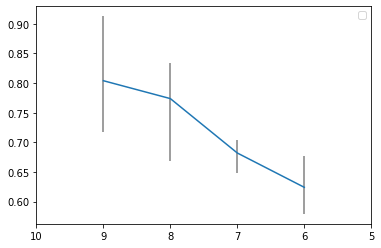

In [17]:
res_fake_pmc = resulting_kl

print(resulting_kl)

resulting_kl = np.array(resulting_kl)

mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(10, 5)

plt.legend()
plt.show()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')


# ABC PMC

In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [9, 8, 7, 6]
resulting_kl = []

for error in error_thresholds:
    inter_kl = []
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([1.5 * error, 1.3 * error, error]))

        # produce intermediate distributions of size 500
        abc.sampler().set_intermediate_size(500)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        samples_flat = samples

        # computing the KDE and KL functions for x

        def marginal_distribution_x(x):
            partial_lam = lambda y : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0.5, 2)[0]

        def kl_func_x(y, kde_skl):
            part = marginal_distribution_x(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_x(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_x(y, kde_skl)
            return integrate.quad(fun, 0.013, 0.3)

        saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

        # computing the KDE and KL functions for x
        def marginal_distribution_y(y):
            partial_lam = lambda x : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0, 0.3)[0]

        def kl_func_y(y, kde_skl):
            part = marginal_distribution_y(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_y(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_y(y, kde_skl)
            return integrate.quad(fun, 0.5, 2)

        saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
        saved = saved_x + saved_y
        inter_kl.append(saved)

        print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))
    resulting_kl.append(inter_kl)

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=11.700000000000001
Trying t=2, threshold=9.0
Iter. Eval. Acceptance rate Time m:s
1     1153   0.000867302689   1:15.0
2     1154   0.00173310225    1:15.1
3     1155   0.0025974026     1:15.1
20    1173   0.0170502984     1:16.1
40    1196   0.0334448161     1:17.3
60    1219   0.0492206727     1:18.3
80    1240   0.064516129      1:19.3
100   1260   0.0793650794     1:20.2
120   1281   0.093676815      1:21.2
140   1304   0.107361963      1:22.2
160   1326   0.12066365       1:23.2
180   1347   0.13363029       1:24.2
200   1369   0.146092038      1:25.3
220   1392   0.158045977      1:26.4
240   1414   0.169731259      1:27.4
260   1436   0.181058496      1:28.3
280   1460   0.191780822      1:29.4
300   1483   0.20229265       1:30.4
320   1506   0.2124834        1:31.4
340   1528   0.222513089      1:32.5
360   1548   0.23255814       1:33.5
380   1572   0.24173028       1:34.8
400   1594   0.250941029      1:35.6
420

No handles with labels found to put in legend.


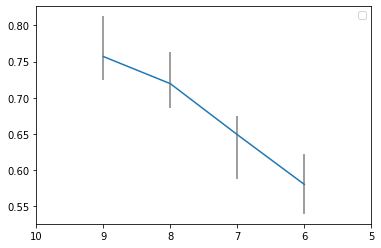

In [19]:
res_true_pmc = resulting_kl

resulting_kl = np.array(resulting_kl)

mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(10, 5)

plt.legend()
plt.show()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')

# All errors

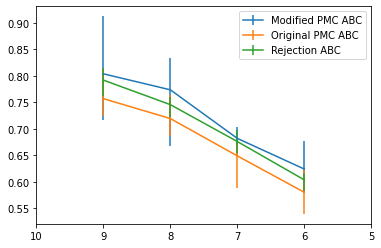

In [24]:
res_fake_pmc = np.array(res_fake_pmc)
res_true_pmc = np.array(res_true_pmc)
res_rej_abc = np.array(res_rej_abc)

mins_fake_pmc_kl = res_fake_pmc.min(1)
maxes_fake_pmc_kl = res_fake_pmc.max(1)
means_fake_pmc_kl = res_fake_pmc.mean(1)

mins_true_pmc_kl = res_true_pmc.min(1)
maxes_true_pmc_kl = res_true_pmc.max(1)
means_true_pmc_kl = res_true_pmc.mean(1)

mins_abc_rej_kl = res_rej_abc.min(1)
maxes_abc_rej_kl = res_rej_abc.max(1)
means_abc_rej_kl = res_rej_abc.mean(1)

plt.errorbar(error_thresholds, means_fake_pmc_kl, [means_fake_pmc_kl - mins_fake_pmc_kl, maxes_fake_pmc_kl - means_fake_pmc_kl], label='Modified PMC ABC')
plt.errorbar(error_thresholds, means_true_pmc_kl, [means_true_pmc_kl - mins_true_pmc_kl, maxes_true_pmc_kl - means_true_pmc_kl], label='Original PMC ABC')
plt.errorbar(error_thresholds, means_abc_rej_kl, [means_abc_rej_kl - mins_abc_rej_kl, maxes_abc_rej_kl - means_abc_rej_kl], label='Rejection ABC')
plt.xlim(10, 5)
plt.legend()
# plt.show()


# print(res_fake_pmc)

# ax.plot(error_thresholds, res_fake_pmc, label='Modified PMC ABC')
# ax.plot(error_thresholds, res_true_pmc, label='Original PMC ABC')
# ax.plot(error_thresholds, res_rej_abc, label='Rejection ABC')
# ax.set_xlim(10, 5)
# ax.grid(True)
# ax.legend()
# plt.show()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/production_degradation_errors_all.pdf')

# Adaptive PMC ABC

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [0.6, 0.5, 0.4, 0.3]
resulting_kl = []

for error in error_thresholds:
    inter_kl = []
    for i in range(5):
        print("trying error="+str(error))
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

        # set threshold
        abc.sampler().set_N_l(150)

        # set p_acc_min
        abc.sampler().set_p_acc_min(error)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        print('Running...')
        samples  = abc.run()
        print('Done')

        samples_flat = samples

        # computing the KDE and KL functions for x

        def marginal_distribution_x(x):
            partial_lam = lambda y : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0.5, 2)[0]

        def kl_func_x(y, kde_skl):
            part = marginal_distribution_x(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_x(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_x(y, kde_skl)
            return integrate.quad(fun, 0.013, 0.3)

        saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

        # computing the KDE and KL functions for x
        def marginal_distribution_y(y):
            partial_lam = lambda x : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0, 0.3)[0]

        def kl_func_y(y, kde_skl):
            part = marginal_distribution_y(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_y(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_y(y, kde_skl)
            return integrate.quad(fun, 0.5, 2)

        saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
        saved = saved_x + saved_y
        inter_kl.append(saved)

        print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))
    resulting_kl.append(inter_kl)

trying error=0.6
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.1739378  1.36064895]
resulting var=[[0.00872226 0.04697379]
 [0.04697379 0.34398837]]
epsilon=4.696807426326951
w_mean=[0.16779423 1.47079507]
resulting var=[[0.00565645 0.03804576]
 [0.03804576 0.33740296]]
Iter. Eval. Acceptance rate Time m:s
1     3      166.6666666667   1:09.4
Halting: target number of samples (500) reached.
Done
saved_x=0.47297194387789404, saved_y=0.0851641521662651
trying error=0.6
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.16547028 1.38636028]
resulting var=[[0.00717644 0.04097696]
 [0.04097696 0.34949113]]
Iter. Eval. Acceptance rate Time m:s
1     2      250              0:48.2
Halting: target number of samples (500) reached.
Done
saved_x=0.5214640430068896, saved_y=0.08389163922882792
trying error=0.6
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.17108398 1.39365196]
resulting var=[[0.00699181 0.03861134]
 [0.0386113

In [10]:
res_adaptive = resulting_kl

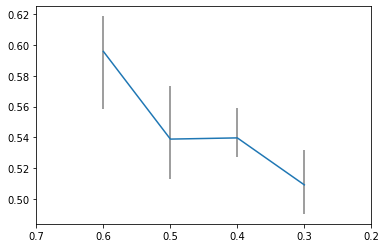

In [16]:
resulting_kl = np.array(resulting_kl)

mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(0.7, 0.2)

# plt.legend()
# plt.show()

# ax.plot(error_thresholds, res_true_pmc, label='Original PMC ABC')
# ax.plot(error_thresholds, res_rej_abc, label='Rejection ABC')


import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/production_degradation_errors_adaptive.pdf')

In [25]:
print(res_fake_pmc)

[[0.91269771 0.72027288 0.87755215 0.79224802 0.7167696 ]
 [0.83410061 0.81315085 0.66821163 0.74529651 0.80786673]
 [0.69480002 0.688582   0.64865837 0.67369686 0.70398093]
 [0.63040684 0.59393334 0.579185   0.63964907 0.67705782]]


In [26]:
print(res_true_pmc)

[[0.76972686 0.74845162 0.7288782  0.81272233 0.72505111]
 [0.76298297 0.69125619 0.71252717 0.74451029 0.68584691]
 [0.64638751 0.67308885 0.66331783 0.67403931 0.58761637]
 [0.57517588 0.58737834 0.53927101 0.57602678 0.62274245]]


In [27]:
print(res_rej_abc)

[[0.79340372 0.81440304 0.76213187 0.78828906 0.80180155]
 [0.74720146 0.72284114 0.74109486 0.7608119  0.75649779]
 [0.67432695 0.65455188 0.69776608 0.69469176 0.65855075]
 [0.60023909 0.610994   0.60837458 0.58259684 0.61570823]]


In [14]:
print(res_adaptive)

[[0.5581360960441591, 0.6053556822357176, 0.6185117477174353, 0.6032385806552362, 0.5932479487204142], [0.5133224108727681, 0.5354863779217146, 0.5372541876111436, 0.5735082974042279, 0.5348730981224329], [0.5590034024517797, 0.527582179280456, 0.5383706557795231, 0.5380867385325854, 0.5353230314064426], [0.510922464275488, 0.5136720440876533, 0.5316575649161546, 0.49040165181760775, 0.4995151294076225]]
